<a href="https://colab.research.google.com/github/dajuctech/Applied-AI-Course/blob/main/Time%20Series%20Analysis/Time_Series_Models_Part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Models (Part 1)

This notebook contains the practical examples and exercises for the Applied AI-Time Series Models.

*Adapted from a tutorial by Dr Iain Rice. Modified by Hansi Hettiarachchi.*

**Importing Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import statsmodels.api as sm
import itertools
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from scipy.spatial.distance import cdist

**Explanation:**

* Import necessary libraries for data manipulation, visualization, and time series modeling.
* Libraries such as statsmodels and sklearn help perform statistical analysis, time series forecasting, and accuracy measurement.

**Reason:** These libraries provide essential functions for time series analysis, such as building models, performing statistical tests, and calculating forecast errors.

# ARMA

**Loading and Viewing Data (CO2 Dataset)**

In [2]:
# load co2 data from stat models
dataset = sm.datasets.co2.load_pandas()

# get DataFrame in Dataset Object returned by stat models
df = dataset.data

print(df.shape)
df.head(15)

(2284, 1)


,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4
1958-05-03,316.9
1958-05-10,NaN
1958-05-17,317.5
1958-05-24,317.9
1958-05-31,NaN


**Explanation:**

* Load the CO2 dataset using statsmodels.
* Display the first 15 rows to understand the data structure.

**Reason:** This allows us to preview the dataset and its dimensions (e.g., time series with CO2 levels).



**Data Wrangling and Missing Values**

## Data Wrangling


1.   Formatting
2.   Imputing missing values



Pandas [DateOffset objects](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects)

In [3]:
# calculate mean value per month and assigned in to the calendar month begin date (DateOffset string - 'MS')
df = df.resample('MS').mean()

print(df.shape)
df.head()

(526, 1)


,co2
1958-03-01,316.100000
1958-04-01,317.200000
1958-05-01,317.433333
1958-06-01,NaN
1958-07-01,315.625000


**Explanation:**

* Resample the data to monthly frequency ('MS'), taking the mean for each month.
* Identify missing values and fill them using backward fill (replacing missing values with the next available value).

**Reason:** Handling missing values ensures the time series is continuous, a requirement for reliable modeling and forecasting.

In [4]:
# find if the data set contains Null/NaN value
df.isna().sum()

,0
co2,5


In [5]:
# impute missing values
# dataframe.bfill() is used to backward fill the missing values in the dataset.
df = df.fillna(df.bfill())
df.head()

,co2
1958-03-01,316.100000
1958-04-01,317.200000
1958-05-01,317.433333
1958-06-01,315.625000
1958-07-01,315.625000


**Plotting Time Series Data**

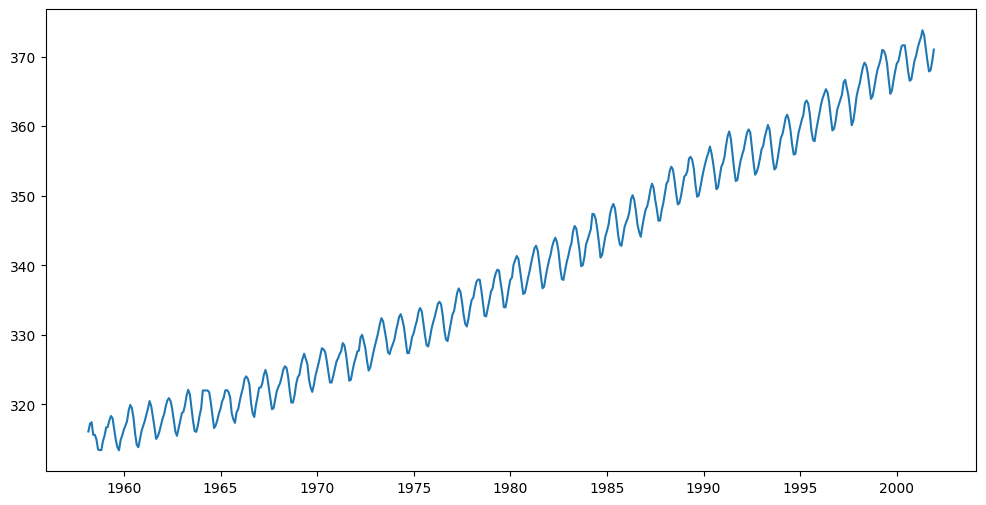

In [6]:
# plot time series
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['co2'])
plt.show()

**Explanation:**

* Plot the time series to visualize patterns such as trends and seasonality.

**Reason:** Visualizing the data helps identify features like periodicity, stationarity, and outliers, which influence model selection.

**Stationarity Check**

In [7]:
# check stationarity of the series
def check_stationarity(series):
  statistic, p_value, n_lags, critical_values = sm.tsa.stattools.kpss(series)
  print(f'p value: {p_value}')
  print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary \n')

In [8]:
check_stationarity(df['co2'])

p value: 0.01
Result: The series is not stationary 



<ipython-input-7-0229352fdffd>:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, n_lags, critical_values = sm.tsa.stattools.kpss(series)


**Explanation:**

* Use the KPSS test to check if the series is stationary.
* A p-value below 0.05 indicates non-stationarity.

**Reason:** Most time series models (e.g., ARIMA) require stationarity. If non-stationary, we may need to apply differencing or transformations.

**Building a SARIMA Model**

## Forecasting

Since the data has a seasonal component, we can use a SARIMA model.

[statsmodels SARIMAX- Documentation](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html)

[statsmodels SARIMAX Results-Documentation](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.html)

In [9]:
# order - The (p,d,q) order of the model for the number of AR parameters, differences, and MA parameters.
# seasonal_order - The (P,D,Q,s) order of the seasonal component of the model for the AR parameters, differences, MA parameters, and periodicity.
model = sm.tsa.statespace.SARIMAX(df['co2'],
                                  order=(0, 0, 1),
                                  seasonal_order=(0, 0, 0, 12),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
# train model
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    co2   No. Observations:                  526
Model:               SARIMAX(0, 0, 1)   Log Likelihood               -3438.524
Date:                Mon, 10 Feb 2025   AIC                           6881.049
Time:                        09:29:32   BIC                           6889.572
Sample:                    03-01-1958   HQIC                          6884.386
                         - 12-01-2001                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          1.0000     40.815      0.025      0.980     -78.995      80.995
sigma2      2.899e+04   1.19e+06      0.024      0.981    -2.3e+06    2.35e+06
Ljung-Box (L1) (Q):                 282.92   Jarque-

**Explanation:**

* Define and train a SARIMA model with specified parameters:
    * Order: (p, d, q) for autoregressive, differencing, and moving average terms.
    * Seasonal order: (P, D, Q, s) for seasonality components.
* Print the model summary for diagnostics.

**Reason:** SARIMA handles both trend and seasonal patterns, making it suitable for periodic data like CO2 levels.

**Making Predictions**

In [10]:
# make predictions
preds = model_fit.predict(start=pd.to_datetime('2001-01-01'), end=pd.to_datetime('2001-12-01'), dynamic=False)
print(preds)

2001-01-01    187.832184
2001-02-01    181.988082
2001-03-01    188.969293
2001-04-01    182.735899
2001-05-01    189.671540
2001-06-01    183.773018
2001-07-01    188.922286
2001-08-01    182.027006
2001-09-01    187.038324
2001-10-01    180.495254
2001-11-01    187.196151
2001-12-01    181.831197
Freq: MS, Name: predicted_mean, dtype: float64


In [11]:
# Out-of-sample forecasts
forecasts = model_fit.forecast(steps=1)
print(forecasts)

2002-01-01    188.828462
Freq: MS, dtype: float64


More model examples on how to use the other variant of ARMA models are available [here](https://www.statsmodels.org/stable/examples/index.html#time-series-analysis).

Let's go through all possible parameter combinations to identify the best.

**Explanation:**

* Use the trained model to predict future values.
* predict() generates values within the training period, while forecast() predicts beyond it.

**Reason:** This step tests the model's ability to generalize and predict unseen data.

**Grid Search for Best Model Parameters**

In [12]:
p = d = q = range(0, 3)

# generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
# generate all different combinations of seasonal p, q and q triplets
# seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
seasonal_pdq = [(1, 1, 1, 12)]

for param in pdq:
    for param_seasonal in seasonal_pdq:
          mod = sm.tsa.statespace.SARIMAX(df['co2'],
                                          order=param,
                                          seasonal_order=param_seasonal,
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)

          mod_fit = mod.fit()

          print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, mod_fit.aic))

ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1044.7647912841048
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:807.09129881839
ARIMA(0, 0, 2)x(1, 1, 1, 12)12 - AIC:700.9035655116618
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:323.324653292323
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:281.5190179449173
ARIMA(0, 1, 2)x(1, 1, 1, 12)12 - AIC:279.8741921510342
ARIMA(0, 2, 0)x(1, 1, 1, 12)12 - AIC:781.4979258233545
ARIMA(0, 2, 1)x(1, 1, 1, 12)12 - AIC:332.5321368212596
ARIMA(0, 2, 2)x(1, 1, 1, 12)12 - AIC:290.7189898270581
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:329.58449915644667
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:284.3596456645412
ARIMA(1, 0, 2)x(1, 1, 1, 12)12 - AIC:282.9995858568891
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:293.7426231817366
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:277.7802190184549
ARIMA(1, 1, 2)x(1, 1, 1, 12)12 - AIC:278.9864240917606
ARIMA(1, 2, 0)x(1, 1, 1, 12)12 - AIC:572.1786410445648
ARIMA(1, 2, 1)x(1, 1, 1, 12)12 - AIC:303.990535355818
ARIMA(1, 2, 2)x(1, 1, 1, 12)12 - AIC:286.33630837638617
ARIMA(2, 0,

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1)x(1, 1, 1, 12)12 - AIC:279.44847734234173


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2)x(1, 1, 1, 12)12 - AIC:281.1044506402935
ARIMA(2, 1, 0)x(1, 1, 1, 12)12 - AIC:288.9646785014062
ARIMA(2, 1, 1)x(1, 1, 1, 12)12 - AIC:281.63283642808113
ARIMA(2, 1, 2)x(1, 1, 1, 12)12 - AIC:281.4750617793771
ARIMA(2, 2, 0)x(1, 1, 1, 12)12 - AIC:501.109451651102
ARIMA(2, 2, 1)x(1, 1, 1, 12)12 - AIC:297.0927214198952


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2)x(1, 1, 1, 12)12 - AIC:288.0748204326834


**Explanation:**

* Generate all combinations of model parameters (p, d, q) and evaluate each with the AIC (Akaike Information Criterion).
* The lower the AIC, the better the model fit.

**Reason:** This process helps find the optimal parameters for the SARIMA model, improving forecast accuracy.

**Evaluating Model Performance**

In [13]:
# specify model
model = sm.tsa.statespace.SARIMAX(df['co2'],
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
# train model
model_fit = model.fit()

# make predictions
preds = model_fit.predict(start=pd.to_datetime('1998-01-01'), dynamic=False)

# calculate MSE
actuals = df['1998-01-01':]
print(f'Mean Squared Error: {round(mean_squared_error(actuals, preds), 2)}')

Mean Squared Error: 0.07


**Explanation:**

* Compare predictions to actual values and compute the Mean Squared Error (MSE) to assess model accuracy.

**Reason:** MSE measures prediction errors; lower values indicate better performance.

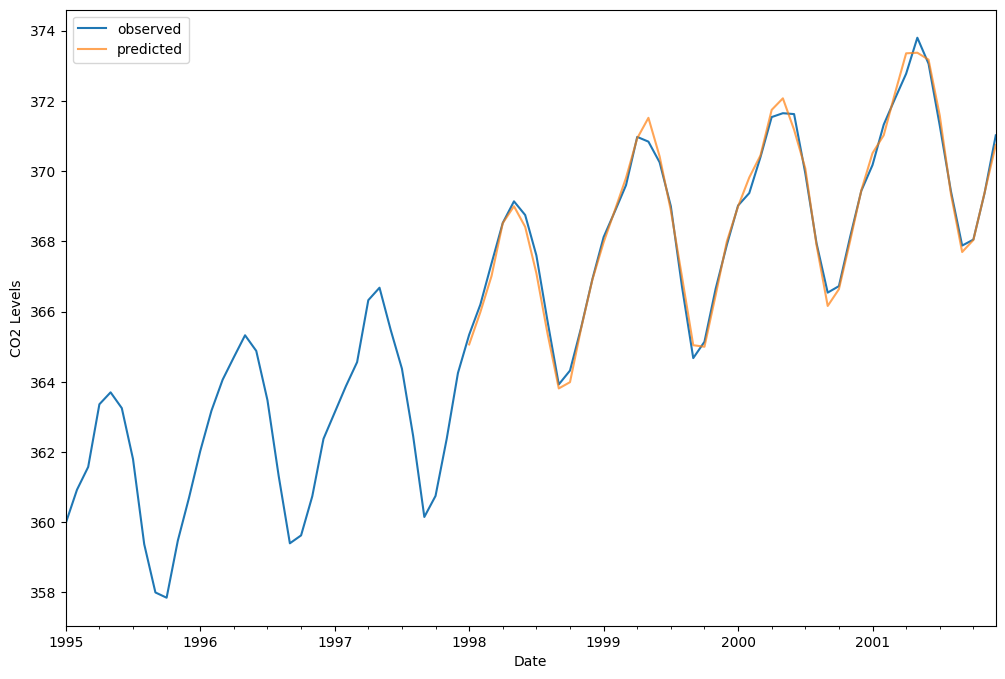

In [14]:
# plot observations and predictions
ax = df['1995':]['co2'].plot(label='observed', figsize=(12, 8))
preds.plot(ax=ax, label='predicted', alpha=.7)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()

plt.show()

**Exercise 1 Build an ARMA model to predict the number of international airline passengers during the first quarter of 1961**

Build an appropriate ARMA model to predict the number of international airline passengers during the months in the first quarter of 1961 using the dataset *international-airline-passengers.csv*.

**Step 1: Import and clean the dataset**

In [67]:
df = pd.read_csv('https://raw.githubusercontent.com/HHansi/Applied-AI-Course/main/Time%20Series%20Analysis/data/international-airline-passengers.csv')
df = df.rename(columns={"International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60": "Sales"})
df['Month-No'] = list(range(0, len(df['Month'])))
df.head()


,Month,Sales,Month-No
0,1949-01,112,0
1,1949-02,118,1
2,1949-03,132,2
3,1949-04,129,3
4,1949-05,121,4


**Explanation:**

* Load the dataset containing passenger information.
* Rename the column for easier access.
* Add a numerical column to represent each month sequentially.

**Step 2: Visualize the time series**

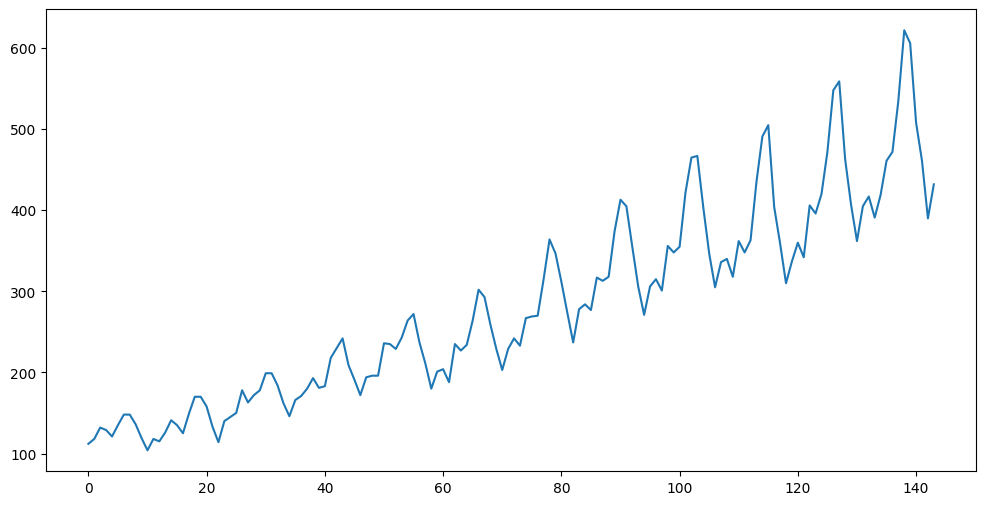

In [68]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Sales'])
plt.show()


**Explanation:**

* Plot the data to visualize the trend, seasonality, and fluctuations in the time series.

**Step 3: Check stationarity**

In [69]:
def check_stationarity(series):
    statistic, p_value, n_lags, critical_values = sm.tsa.stattools.kpss(series)
    print(f'p value: {p_value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary \n')

check_stationarity(df['Sales'])


p value: 0.01
Result: The series is not stationary 



<ipython-input-69-3fe7a11d71c0>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, n_lags, critical_values = sm.tsa.stattools.kpss(series)


**Explanation:**

* The KPSS test checks if the series is stationary.
* A low p-value (< 0.05) indicates the series is not stationary, requiring transformations (e.g., differencing).

**Step 4: Build an ARIMA model**

In [70]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df['Sales'], order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  144
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -694.341
Date:                Mon, 10 Feb 2025   AIC                           1394.683
Time:                        10:05:56   BIC                           1403.571
Sample:                             0   HQIC                          1398.294
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4742      0.123     -3.847      0.000      -0.716      -0.233
ma.L1          0.8635      0.078     11.051      0.000       0.710       1.017
sigma2       961.9270    107.433      8.954      0.0

**Explanation:**

* We use ARIMA (AutoRegressive Integrated Moving Average) to fit the data.
* The (p=1, d=1, q=1) parameters define the autoregression (AR), differencing (I), and moving average (MA) terms.
* The summary() method shows model diagnostics, including AIC (model quality metric).

**Step 5: Make predictions for 1961 Q1**

In [73]:
#preds = model_fit.predict(start=pd.Timestamp('1961-01-01'), end=pd.Timestamp('1961-03-01'), dynamic=False)
#print(preds)

In [72]:
# make predictions for the first quarter of 1961
preds = model_fit.predict(start=144, end=146, dynamic=False)  # Use numeric index values corresponding to '1961-01-01' and '1961-03-01'
print(preds)

144    475.735059
145    454.996073
146    464.830415
Name: predicted_mean, dtype: float64


**Explanation:**

* We predict the passenger counts for January to March 1961.
* The dynamic=False flag means each forecast uses actual data for past observations.

**Exercise 1 Solution: ARMA Model**

In [16]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA  # Import ARIMA

In [18]:
df.head()

,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [19]:
# Load the data
df = pd.read_csv(r'international-airline-passengers.csv')

# Assuming 'International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60' is the actual column name
df = df.rename(columns={"International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60": "Sales"})

# Convert 'Month' to datetime and set it as the index
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

# Create and fit the ARIMA model
model = ARIMA(df['Sales'], order=(1, 1, 1))  # Now accessing the correct 'Sales' column
model_fit = model.fit()

# Make predictions
preds = model_fit.predict(start=pd.Timestamp('1961-01-01'), end=pd.Timestamp('1961-04-01'))
print(preds)

1961-01-01    475.735059
1961-02-01    454.996073
1961-03-01    464.830415
1961-04-01    460.167010
Freq: MS, Name: predicted_mean, dtype: float64


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


**Explanation:**

* Load and preprocess the airline passengers dataset.
* Build and train an ARIMA model, then predict passenger counts for the first quarter of 1961.

**Reason:** This exercise applies ARIMA modeling to new data, reinforcing concepts from earlier steps.

**importing the dataset**

In [20]:
# load the data set
# As the parameter, the file path should be provided. Additionally, GitHub URL can also be provided as follows.
df = pd.read_csv(r'international-airline-passengers.csv')

# rename column name
df = df.rename(columns={"International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60": "Sales"})

# convert month to int
df['Month-No'] = list(range(0, len(df['Month'])))

df.head()

,Month,Sales,Month-No
0,1949-01,112,0
1,1949-02,118,1
2,1949-03,132,2
3,1949-04,129,3
4,1949-05,121,4


In [21]:
print(df.columns)

Index(['Month', 'Sales', 'Month-No'], dtype='object')


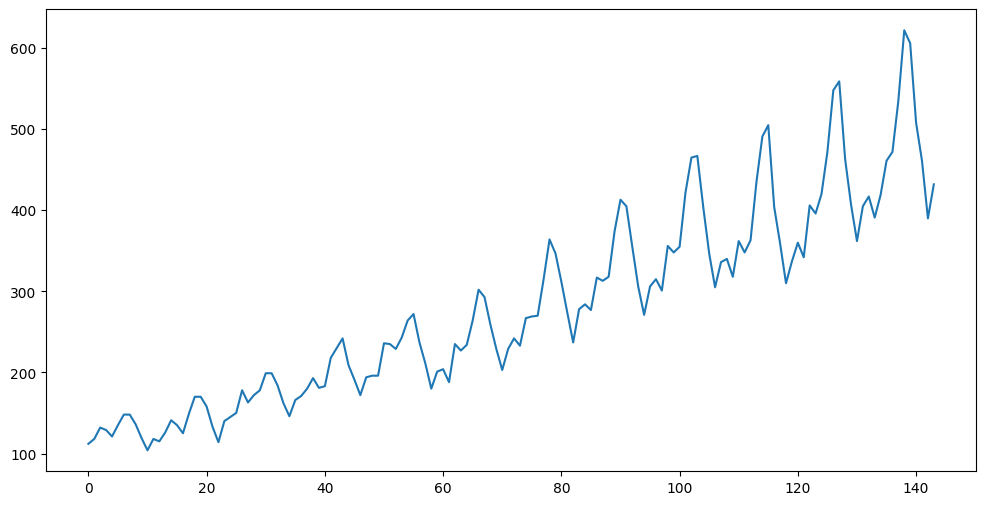

In [22]:
# plot time series
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Sales'])
plt.show()

In [23]:
print(df.columns)

Index(['Month', 'Sales', 'Month-No'], dtype='object')


In [24]:
# check stationarity of the series
def check_stationarity(series):
  statistic, p_value, n_lags, critical_values = sm.tsa.stattools.kpss(series)
  print(f'p value: {p_value}')
  print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary \n')

In [25]:
print(df.columns)

Index(['Month', 'Sales', 'Month-No'], dtype='object')


In [26]:
check_stationarity(df['Sales'])

p value: 0.01
Result: The series is not stationary 



<ipython-input-24-0229352fdffd>:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, n_lags, critical_values = sm.tsa.stattools.kpss(series)


In [27]:
print(df.columns)

Index(['Month', 'Sales', 'Month-No'], dtype='object')


In [28]:
# order - The (p,d,q) order of the model for the number of AR parameters, differences, and MA parameters.
# seasonal_order - The (P,D,Q,s) order of the seasonal component of the model for the AR parameters, differences, MA parameters, and periodicity.
# Import the ARIMA model from the correct location
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df['Sales'],
              order=(0, 0, 1),
              seasonal_order=(0, 0, 0, 12),
              enforce_stationarity=False,
              enforce_invertibility=False)
# train model
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  144
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -794.429
Date:                Mon, 10 Feb 2025   AIC                           1594.857
Time:                        09:40:46   BIC                           1603.725
Sample:                             0   HQIC                          1598.460
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        283.0120     11.709     24.170      0.000     260.062     305.962
ma.L1          1.0372      0.032     31.963      0.000       0.974       1.101
sigma2      3865.2605    612.601      6.310      0.0

In [29]:
print(df.columns)

Index(['Month', 'Sales', 'Month-No'], dtype='object')


In [30]:
print(model_fit.data.dates)  # If you used a time series with Statsmodels


None


In [31]:
print(df.columns)

Index(['Month', 'Sales', 'Month-No'], dtype='object')


In [32]:
df.head()

,Month,Sales,Month-No
0,1949-01,112,0
1,1949-02,118,1
2,1949-03,132,2
3,1949-04,129,3
4,1949-05,121,4


In [33]:
print(df.columns)

Index(['Month', 'Sales', 'Month-No'], dtype='object')


In [35]:
# make predictions for the first quarter of 1961
#preds = model_fit.predict(start=pd.Timestamp('1961-01-01 00:00:00'), end=pd.to_datetime('1961-04-01 00:00:00'), dynamic=False)
preds = model_fit.predict(start=144, end=146, dynamic=False)
print(preds)

144    426.277699
145    283.011955
146    283.011955
Name: predicted_mean, dtype: float64


In [36]:
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

In [ ]:
if 'Month' not in df.columns:
    print("The 'Month' column does not exist.")
else:
    df['Month'] = pd.to_datetime(df['Month'])
    df.set_index('Month', inplace=True)


In [ ]:
print(df.columns)


Index(['Sales', 'Month-No'], dtype='object')


**Exponential Smoothing**

# Exponential Smoothing

In [38]:
# load the data set
# As the parameter, the file path should be provided. Additionally, GitHub URL can also be provided as follows.
df = pd.read_csv('https://raw.githubusercontent.com/HHansi/Applied-AI-Course/main/Time%20Series%20Analysis/data/international-airline-passengers.csv')

# rename column name
df = df.rename(columns={"International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60": "Sales"})

# convert month to int
df['Month-No'] = list(range(0, len(df['Month'])))

df.head()

,Month,Sales,Month-No
0,1949-01,112,0
1,1949-02,118,1
2,1949-03,132,2
3,1949-04,129,3
4,1949-05,121,4


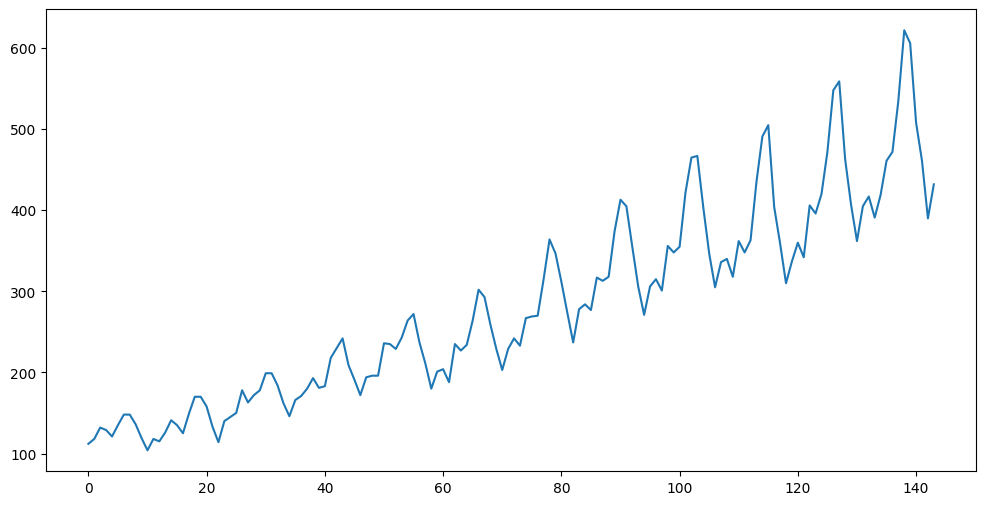

In [39]:
# plot time series
plt.figure(figsize=(12, 6))
plt.plot(df["Month-No"],df["Sales"])
plt.show()

Documentation:
* [SimpleExpSmoothing](https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.SimpleExpSmoothing.html)
* [Holt](https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.Holt.html#statsmodels.tsa.holtwinters.Holt)
* [ExponentialSmoothing](https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html#statsmodels.tsa.holtwinters.ExponentialSmoothing)

In the following, we use auto optimization instead of choosing model parameters manually.

More examples on exponential smoothing are available [here](https://www.statsmodels.org/stable/examples/notebooks/generated/exponential_smoothing.html#Simple-Exponential-Smoothing). Additionally, a tutorial is available [here](https://medium.com/analytics-vidhya/python-code-on-holt-winters-forecasting-3843808a9873).


In [40]:
# single exponential smoothing
single_fit = SimpleExpSmoothing(df["Sales"]).fit()

# double exponential smoothing
double_fit = Holt(df["Sales"]).fit()

# triple exponential smoothing
tripple_fit = ExponentialSmoothing(df["Sales"], trend="mul",seasonal="mul", seasonal_periods=12).fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


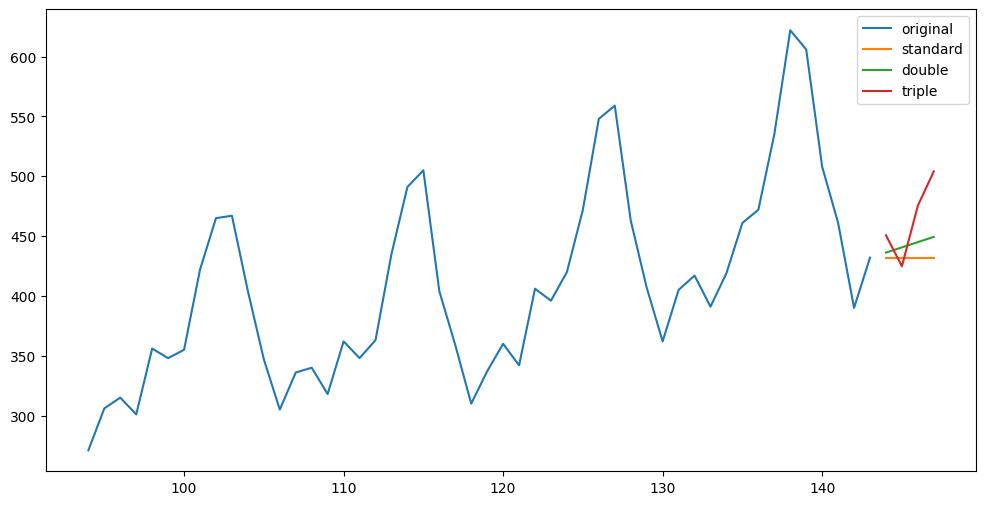

In [41]:
# future predictions
predictions_single_fit = single_fit.forecast(4)
predictions_double_fit = double_fit.forecast(4)
predictions_tripple_fit = tripple_fit.forecast(4)

# plot data
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df["Month-No"][-50:], df["Sales"][-50:], label='original')

plt.plot(predictions_single_fit, label='standard')
plt.plot(predictions_double_fit, label='double')
plt.plot(predictions_tripple_fit, label='triple')

plt.legend()
plt.show()

**Explanation:**

* Apply different types of exponential smoothing:
    * Simple (for data without trend or seasonality),
    * Double (for trend),
    * Triple (for both trend and seasonality).
* Generate forecasts for the next 4 periods.

**Reason:** Exponential smoothing is a popular forecasting method for time series with varying patterns.

**Exercise 2 Compare predictions from exponential smoothing with ARIMA**

Compare the predictions made using exponential smoothing above and the model you built in exercise 1 on the international airline passengers dataset.

**Step 1: Apply exponential smoothing methods**

In [74]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing

single_fit = SimpleExpSmoothing(df["Sales"]).fit()
double_fit = Holt(df["Sales"]).fit()
tripple_fit = ExponentialSmoothing(df["Sales"], trend="mul", seasonal="mul", seasonal_periods=12).fit()

predictions_single_fit = single_fit.forecast(4)
predictions_double_fit = double_fit.forecast(4)
predictions_tripple_fit = tripple_fit.forecast(4)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


**Explanation:**

* Apply simple, double, and triple exponential smoothing.
* Forecast the next 4 periods (April 1960 to July 1960).

**Step 2: Plot and compare results**

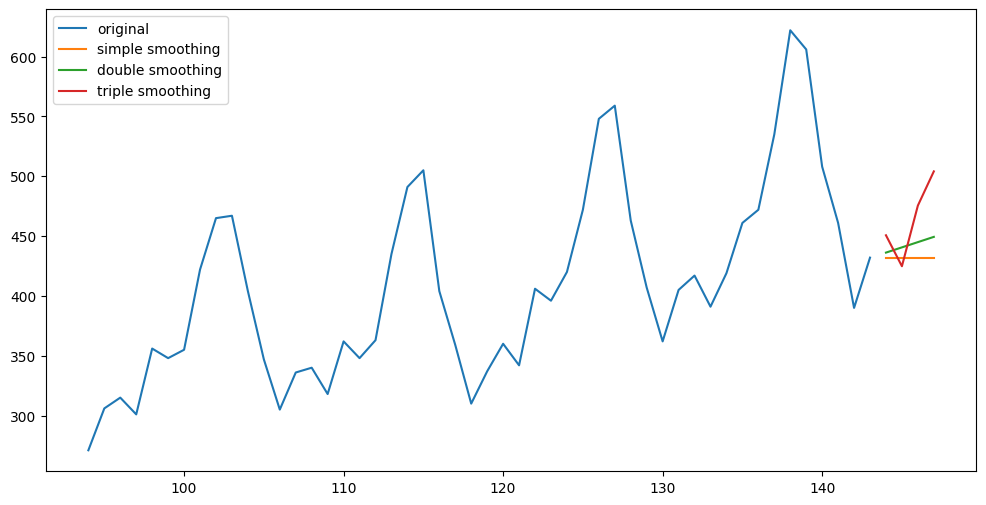

In [75]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df["Month-No"][-50:], df["Sales"][-50:], label='original')

plt.plot(predictions_single_fit, label='simple smoothing')
plt.plot(predictions_double_fit, label='double smoothing')
plt.plot(predictions_tripple_fit, label='triple smoothing')

plt.legend()
plt.show()


**Explanation:**

* Visualize the original series and predictions from each smoothing method.
* Compare these forecasts with those from the ARIMA model to see which performs better.

# **Lorenz Method of Analogues (LMA)**

Example with City Temperatures Dataset. Need to do some data pre-processing and wrangling first.

## **Data Loading**

In [42]:
# mount your Google Drive
from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
# # unzip file
# import shutil
# shutil.unpack_archive('/content/drive/MyDrive/Colab Notebooks/Applied-AI/Time-Series/data/city_temperature.zip', '/content/drive/MyDrive/Colab Notebooks/Applied-AI/Time-Series/data', 'zip')

In [43]:
# load data
df = pd.read_csv(r'city_temperature.csv')
df.head()

,Region,Country,State,City,Month,Day,Year,AvgTemperature
0,Africa,Algeria,NaN,Algiers,1,1.0,1995.0,64.2
1,Africa,Algeria,NaN,Algiers,1,2.0,1995.0,49.4
2,Africa,Algeria,NaN,Algiers,1,3.0,1995.0,48.8
3,Africa,Algeria,NaN,Algiers,1,4.0,1995.0,46.4
4,Africa,Algeria,NaN,Algiers,1,5.0,1995.0,47.9


**Explanation:**

* Load a city temperature dataset for further analysis using the Lorenz Method of Analogues (LMA).

**Reason:** LMA requires historical data to find similar patterns (or "analogues") for predictions.

## **Data Wrangling**

In [44]:
# get a statistical summary of the DataFrame
df.describe()

,State,Month,Day,Year,AvgTemperature
count,0.0,721718.000000,721717.000000,721717.000000,721717.000000
mean,NaN,6.470802,15.717783,2006.664460,56.878764
std,NaN,3.457309,8.801035,24.020763,43.761476
min,NaN,1.000000,0.000000,201.000000,-99.000000
25%,NaN,3.000000,8.000000,2001.000000,54.100000
50%,NaN,6.000000,16.000000,2007.000000,70.200000
75%,NaN,9.000000,23.000000,2013.000000,80.400000
max,NaN,12.000000,31.000000,2020.000000,103.700000


In [45]:
# find if the DataFrame contains Null/NaN values
df.isna().sum()

,0
Region,0
Country,0
State,721718
City,0
Month,0
Day,1
Year,1
AvgTemperature,1


In [46]:
# get regions in the dataframe:
df.Region.unique()

array(['Africa', 'Asia', 'Australia/South Pacific', 'Europe'],
      dtype=object)

**Explanation:**

* Generate a statistical summary, count missing values, and identify unique regions.

**Reason:** Preprocessing ensures the data is clean and ready for analysis. Understanding the dataset’s structure helps in making data-driven decisions.

**Temperature Conversion**

So the temperatures are stored in farenheight and as a more modern group we want to work with celsius.

In [47]:
# function to transform farenheight to celsius
def to_celsius(row):
    return round((row-32) * (5/9),1)

# apply the to_celsius function to all values in column 'AvgTemperature'
df['AvgTemperature'] = df['AvgTemperature'].apply(to_celsius)
df.head()

,Region,Country,State,City,Month,Day,Year,AvgTemperature
0,Africa,Algeria,NaN,Algiers,1,1.0,1995.0,17.9
1,Africa,Algeria,NaN,Algiers,1,2.0,1995.0,9.7
2,Africa,Algeria,NaN,Algiers,1,3.0,1995.0,9.3
3,Africa,Algeria,NaN,Algiers,1,4.0,1995.0,8.0
4,Africa,Algeria,NaN,Algiers,1,5.0,1995.0,8.8


**Explanation:**

* Convert the temperature from Fahrenheit to Celsius using a transformation function.

**Reason:** Celsius may be more intuitive for analysis, especially in regions where it is standard.

**Grouping and Filtering Data**

We can get a summary of what's going on within a dataset by grouping subcategories together.

In [49]:
# get the averages of the dataframe for each Region-Country-State-City and Year
df.groupby(['Region','Country','State','City','Year']).mean()

,,,,,Month,Day,AvgTemperature
Region,Country,State,City,Year,,,


Sometimes we know what city we want information for so can get a *slice* of the dataframe for subsequent plotting and analysis.

In [51]:
# get data of 'Vienna'
vienna = df[df['City']=='Vienna'].copy()
vienna.head()

# get the averages of the dataframe for year
# vienna = vienna.groupby(['Year']).mean() # This line caused the error
vienna = vienna.groupby(['Year'])['AvgTemperature'].mean() #Only calculate mean for AvgTemperature

# vienna = vienna.drop(columns=['Month','Day']) # This line is no longer needed
vienna = vienna.to_frame() # Convert the Series back to a DataFrame
vienna.head()

,AvgTemperature
Year,
1995.0,10.137260
1996.0,8.710109
1997.0,9.825479
1998.0,9.827671
1999.0,10.301096


**Explanation:**

* Filter data for the city Vienna, calculate yearly averages, and remove unnecessary columns.

**Reason:** Aggregating data by year reduces noise and highlights long-term trends, which can improve forecasting.

**Visualizing Trends**

Let's see a plot to get a really good idea of what's gone on here.

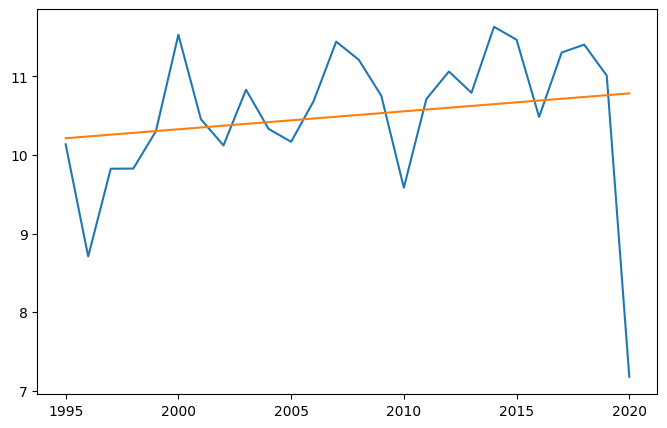

In [52]:
# Plotting a line chart
plt.figure(figsize=(8, 5))
plt.plot(vienna.index, vienna['AvgTemperature'])

# fit a linear regression (trend)
m, b = np.polyfit(vienna.index, vienna['AvgTemperature'], 1)
plt.plot(vienna.index, m * vienna.index + b)

So here we've got an idea of what's going on, but there's a significant drop in 2020. What could be causing this? Let's explore and see the values for each year to check that 2020 is plotting correctly. Then let's view the time series for 2018-2020 and see what's going on with the trend.

**Explanation:**

* Plot the average temperature trend over time.
* Fit and plot a linear regression line to observe long-term patterns.

**Reason:** Linear regression helps detect trends, which may indicate gradual climate changes or anomalies.

In [53]:
vienna.tail()

,AvgTemperature
Year,
2016.0,10.484699
2017.0,11.304384
2018.0,11.404384
2019.0,11.010959
2020.0,7.178358


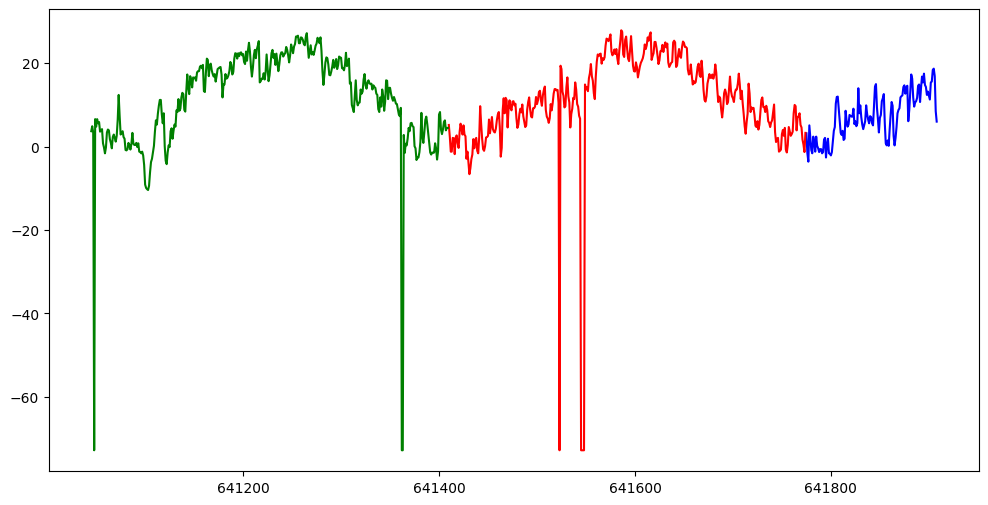

In [54]:
sliced = df[df['City']=='Vienna'].copy()

plt.figure(figsize=(12, 6))

# plot 2020 temperature values
sliced_20 = sliced[sliced['Year']==2020]
plt.plot(sliced_20.index, sliced_20['AvgTemperature'], color='b')

# plot 2019 temperature values
sliced_19 = sliced[sliced['Year']==2019]
plt.plot(sliced_19.index, sliced_19['AvgTemperature'], color='r')

# plot 2018 temperature values
sliced_18 = sliced[sliced['Year']==2018]
plt.plot(sliced_18.index, sliced_18['AvgTemperature'], color='g')

So we should notice why 2020 is looking different on the averages listed above from this plot. What this has also highlighted is the fact that there are some uncharacteristically low values in 2018 and 2019. This data may actually need cleaning to avoid undue effects on subsequent modelling.

**Handling Data Anomalies**

In [55]:
print(f"Number of null values: {sum(sliced_18['AvgTemperature'].isnull())}")
print(f"Number of N\A values: {sum(sliced_18['AvgTemperature'].isna())}")
print(f"Number of low values (<-20): {sum(sliced_18['AvgTemperature']<-20)}")

Number of null values: 0
Number of N\A values: 0
Number of low values (<-20): 3


Let's look into these 3 low values in more detail.

In [56]:
print(sliced_18[sliced_18['AvgTemperature']<-20])

        Region  Country  State    City  Month   Day    Year  AvgTemperature
641048  Europe  Austria    NaN  Vienna      1   4.0  2018.0           -72.8
641362  Europe  Austria    NaN  Vienna     11  14.0  2018.0           -72.8
641363  Europe  Austria    NaN  Vienna     11  15.0  2018.0           -72.8


So there is clearly values included here in error since Vienna couldn't have -72.8 Celsius weather on these three days. We have a few options here to *clean* this bad data:

i)  We can cut it from the dataframe

ii) We can *impute* it

In [57]:
# get indices of bad data
sliced_18[sliced_18['AvgTemperature']<-20].index

Index([641048, 641362, 641363], dtype='int64')

In [58]:
# print the shape - (row,column)
print(sliced_18.shape)

# remove the row with index 641048
sliced_18 = sliced_18.drop(index=641048)

print(sliced_18.shape)

(365, 8)
(364, 8)


Now let's impute the remaining bad value pair using the mean of the data either side, or the median  of the month.

In [59]:
print(sliced_18.loc[641360:641365])

        Region  Country  State    City  Month   Day    Year  AvgTemperature
641360  Europe  Austria    NaN  Vienna     11  12.0  2018.0             7.3
641361  Europe  Austria    NaN  Vienna     11  13.0  2018.0             9.3
641362  Europe  Austria    NaN  Vienna     11  14.0  2018.0           -72.8
641363  Europe  Austria    NaN  Vienna     11  15.0  2018.0           -72.8
641364  Europe  Austria    NaN  Vienna     11  16.0  2018.0             2.8
641365  Europe  Austria    NaN  Vienna     11  17.0  2018.0            -1.5


In [60]:
# replace 'AvgTemperature' at row index 641362 by the average of values at row indices 641361 and 641364
sliced_18.at[641362,'AvgTemperature'] = 0.5*(sliced_18.at[641361,'AvgTemperature'] + sliced_18.at[641364,'AvgTemperature'])

print(sliced_18.loc[641360:641365])

        Region  Country  State    City  Month   Day    Year  AvgTemperature
641360  Europe  Austria    NaN  Vienna     11  12.0  2018.0            7.30
641361  Europe  Austria    NaN  Vienna     11  13.0  2018.0            9.30
641362  Europe  Austria    NaN  Vienna     11  14.0  2018.0            6.05
641363  Europe  Austria    NaN  Vienna     11  15.0  2018.0          -72.80
641364  Europe  Austria    NaN  Vienna     11  16.0  2018.0            2.80
641365  Europe  Austria    NaN  Vienna     11  17.0  2018.0           -1.50


In [61]:
# replace 'AvgTemperature' at row index 641363 by the median of values at row indices 641355-641361
sliced_18.at[641363,'AvgTemperature'] = sliced_18.loc[641355:641361,"AvgTemperature"].median()

print(sliced_18.loc[641360:641365])

        Region  Country  State    City  Month   Day    Year  AvgTemperature
641360  Europe  Austria    NaN  Vienna     11  12.0  2018.0            7.30
641361  Europe  Austria    NaN  Vienna     11  13.0  2018.0            9.30
641362  Europe  Austria    NaN  Vienna     11  14.0  2018.0            6.05
641363  Europe  Austria    NaN  Vienna     11  15.0  2018.0            9.30
641364  Europe  Austria    NaN  Vienna     11  16.0  2018.0            2.80
641365  Europe  Austria    NaN  Vienna     11  17.0  2018.0           -1.50


So now we've dropped one from the dataset, replaced another with the mean of surrounding points and the other with the median.

Let's look at the updated plot now.

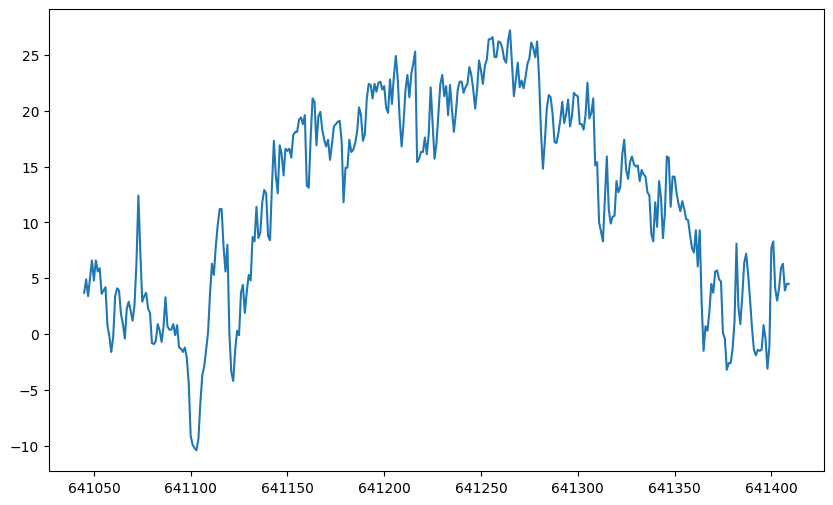

In [62]:
plt.figure(figsize=(10, 6))
plt.plot(sliced_18.index, sliced_18['AvgTemperature'])

In [ ]:
#sliced_18[sliced_18['AvgTemperature'] < -20].index
#sliced_18 = sliced_18.drop(index=641048)
#sliced_18.at[641362, 'AvgTemperature'] = (sliced_18.at[641361, 'AvgTemperature'] + sliced_18.at[641364, 'AvgTemperature']) / 2
#sliced_18.at[641363, 'AvgTemperature'] = sliced_18.loc[641355:641361, "AvgTemperature"].median()


**Explanation:**

* Identify and remove extreme outliers (e.g., temperatures below -20°C).
* Impute missing values by taking the mean or median of nearby data points.

**Reason:** Cleaning the data improves the reliability of modeling by removing erroneous values.

## **Forecasting with Delay Embedding (LMA)**

In [63]:
# get values in column 'AvgTemperature' as a numpy array
x = sliced_18['AvgTemperature'].to_numpy()

# get delay embedding series
X = np.vstack((x[:-2],x[1:-1],x[2:])).T
print(X.shape)

(362, 3)


In [64]:
# get 250 entries as historic data
history = X[:250,:]
print("Stacked data with delay embedding 3:")
print(history[-5:,:])

# identify target
test = x[252]
print(f"\n Target to predict: {test}")

# get latest data
latest = np.reshape(history[-1,:],(-1,3))
print(f"\n Latest observation:{latest}")

Stacked data with delay embedding 3:
[[19.2 20.8 18.9]
 [20.8 18.9 19.7]
 [18.9 19.7 21. ]
 [19.7 21.  18.6]
 [21.  18.6 19.5]]

 Target to predict: 21.6

 Latest observation:[[21.  18.6 19.5]]


**Explanation:**

* Convert the time series into a delay embedding format, where each row represents past observations used for prediction.

**Reason:** Delay embedding creates a feature matrix that helps the model find patterns over time, which is crucial for LMA.

**Finding Nearest Neighbors for Prediction**

In [65]:
# find data like most recent observation (latest)
z = cdist(history[:-1], latest)
zz = np.argsort(z, axis=0)  # return indices of sorted values

print("Five nearest neighbors from history:")
print(history[zz[:5,0],:])

Five nearest neighbors from history:
[[20.8 18.9 19.7]
 [20.1 18.1 19.8]
 [19.4 18.8 19.6]
 [20.8 16.9 19.5]
 [19.2 19.4 18.8]]


In [66]:
# standard prediction:
pred = x[zz[0,0]+3]
print(f"Standard prediction: {pred}")

# average prediction:
neighbours = 2
pred2 = (1/neighbours)*sum(x[zz[:neighbours,0]+3])
print(f"\nAveraged prediction: {pred2}")

Standard prediction: 21.0

Averaged prediction: 21.45


**Explanation:**

* Use Euclidean distance to find past observations most similar to the current state.
* Make predictions based on the closest neighbor and an average of multiple neighbors.

**Reason:** The Lorenz Method of Analogues assumes that historical patterns can predict future behavior when similar conditions recur.

**Exercise 3 (Impact of Neighbor Count on Prediction)**

1. Change the number of neighbours and see its impact on the final prediction.
* Note : Increasing neighbors may smooth predictions but can also reduce precision.
2. Does a high number of neighbours always give the best prediction?
* Note : Not always. Too many neighbors may introduce noise from less-relevant patterns.



**Step 1: Find nearest neighbors**

In [76]:
from scipy.spatial.distance import cdist

history = X[:250, :]
latest = np.reshape(history[-1, :], (-1, 3))
z = cdist(history[:-1], latest)
zz = np.argsort(z, axis=0)


**Explanation:**

* LMA identifies the nearest neighbors by computing Euclidean distances.
* The function cdist() returns distances between the current observation and all historical points.
* zz stores the indices of sorted neighbors.

**Step 2: Predict with different neighbor counts**

In [77]:
# Standard prediction with 1 neighbor
pred = x[zz[0, 0] + 3]

# Average prediction with 2 neighbors
pred2 = (1 / 2) * sum(x[zz[:2, 0] + 3])

# Average prediction with 5 neighbors
pred5 = (1 / 5) * sum(x[zz[:5, 0] + 3])

print(f"Prediction with 1 neighbor: {pred}")
print(f"Prediction with 2 neighbors: {pred2}")
print(f"Prediction with 5 neighbors: {pred5}")


Prediction with 1 neighbor: 21.0
Prediction with 2 neighbors: 21.45
Prediction with 5 neighbors: 19.139999999999997


**Explanation:**

* Compare predictions made using different neighbor counts.
* Using more neighbors may smooth out noise but might also reduce accuracy by averaging irrelevant data points.

**Observation:**

Increasing neighbors can improve stability but may introduce bias.

**Exercise 4: Data Stationarity and Modeling with LMA**

**Exercise 4 Stationarity Impact on LMA**

1. Make the data stationary and see how it affects the results of LMA.
* Use techniques like differencing or log transformation.
* Stationary data helps LMA by emphasizing short-term fluctuations instead of long-term trends.
2. Pick another city of interest, do necessary data wrangling, and model using LMA.
* Apply similar steps to check for trends, anomalies, and forecasts.


**Step 1: Make the data stationary**

In [79]:
def check_stationarity(series):
    # Drop NaN values before applying the KPSS test
    series = series.dropna()
    statistic, p_value, n_lags, critical_values = sm.tsa.stattools.kpss(series)
    print(f'p value: {p_value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary \n')

In [80]:
df['Log-Sales'] = np.log(df['Sales'])
df['Differenced-Sales'] = df['Log-Sales'].diff().dropna()

check_stationarity(df['Differenced-Sales'])

p value: 0.1
Result: The series is stationary 



<ipython-input-79-82d852dfb8dd>:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags, critical_values = sm.tsa.stattools.kpss(series)


**Explanation:**

* Apply log transformation and differencing to stabilize the series.
* Check stationarity again with the KPSS test.

**Step 2: Apply LMA with the stationary series**

In [81]:
stationary_data = df['Differenced-Sales'].dropna().to_numpy()
X_stationary = np.vstack((stationary_data[:-2], stationary_data[1:-1], stationary_data[2:])).T

history_stationary = X_stationary[:250, :]
latest_stationary = np.reshape(history_stationary[-1, :], (-1, 3))

z_stationary = cdist(history_stationary[:-1], latest_stationary)
zz_stationary = np.argsort(z_stationary, axis=0)

pred_stationary = stationary_data[zz_stationary[0, 0] + 3]
print(f"Prediction with stationary data: {pred_stationary}")


Prediction with stationary data: 0.014815085785140347


**Explanation:**

* Reapply LMA to the stationary data and observe how predictions change.
* The goal is to evaluate if making the data stationary improves prediction accuracy.


**Step 3: Test with another city**

In [83]:
# Before attempting to filter by 'City', reload your city_temperature data
df = pd.read_csv(r'city_temperature.csv')
# ... (continue with your data transformations, including to_celsius function) ...

# Now your code should work
new_city = df[df['City'] == 'Berlin'].copy()
new_city['AvgTemperature'] = new_city['AvgTemperature'].apply(to_celsius)

<ipython-input-83-72c8b6323aae>:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'city_temperature.csv')


In [84]:
new_city = df[df['City'] == 'Berlin'].copy()
new_city['AvgTemperature'] = new_city['AvgTemperature'].apply(to_celsius)


**Explanation:**

Repeat the process for another city to test the robustness of LMA on different data.

**Summary**

This code demonstrates how various time series techniques—like **SARIMA**, **exponential smoothing**, and **LMA**—can handle trends, seasonality, and noise in real-world data. The exercises highlight the importance of data cleaning, model selection, and parameter tuning to improve forecast accuracy.

Let me know if you'd like more insights into any section!